## Solution 3: Iterative solution to the 1D Schrödinger equation
**Key idea**: Avoid constructing the full Hamiltonian matrix (which is an $N\times N$ matrix) and a full diagonalization, which scales like $O(N^3)$ .  Rather, design an algorithm which is computationally much more efficient.

In [6]:
# import modules
import numpy as np
import numpy.linalg as lg
import matplotlib.pyplot as plt
import sys
import time

%matplotlib inline

In [60]:
class schroedinger_1d(object):
    def __init__(self, nmesh=100, xLength=10., natoms=1, Vscale=20., 
                 alpha=0.095, init_method='const', pot_type='square'):
        self.nmesh = nmesh
        self.xLength = xLength
        self.natoms = natoms
        self.alpha = alpha
        self.Vscale = Vscale
        self.mesh, self.dx = np.linspace(0., self.xLength, self.nmesh, 
                                         endpoint=False, retstep=True)
        self.pot_type = pot_type
        self.init_method = init_method
        self.psi_list = []
        self.energy_list = []
        
    def initialize_psi(self):
        if self.init_method=='random':
            psi = self.normalize(np.random.rand(self.mesh.size))
            return psi
        if self.init_method=='const':
            psi = self.normalize(np.ones(self.mesh.size))
            return psi
        
    def get_potential(self):
        if self.pot_type == 'square':
            potential = np.zeros(self.nmesh)
            x1 = 0.2 * xLength
            x2 = 0.8 * xLength
            potential[(self.mesh>x1) & (self.mesh<x2)] = -self.Vscale
            
            return potential
        
        elif self.pot_type == 'sinusoidal':
            return self.Vscale*(np.cos(2*np.pi*self.mesh/(self.xLength/self.natoms)) - 1.)/2.
    
    def get_laplacian(self, psi):
        return (np.roll(psi, 1) - 2.0*psi + np.roll(psi, -1))/(self.dx ** 2)
        
    def get_hamiltonian(self, psi):
        return -0.5 * self.get_laplacian(psi)+self.get_potential()*psi
    
    def get_energy(self, psi):
        return np.dot(psi,self.get_hamiltonian(psi))
    
    def get_residual(self, psi):
        return self.orthogonalize(self.get_hamiltonian(psi) - 
                                  self.get_energy(psi)*psi)
    
    def get_next_psi(self, psi):
        residual = self.get_residual(psi)
        newpsi = self.orthogonalize(psi - self.alpha*residual)
        return self.normalize(newpsi), residual
        
    def get_state(self, max_steps=100000, max_error=1e-10):
        psi=self.initialize_psi()
        intermed_energy = []
        for ii in xrange(max_steps):
            psi, residual = self.get_next_psi(psi)
            energy = self.get_energy(psi)
            intermed_energy.append(energy)
            if lg.norm(residual) <= max_error:
                print('reached convergence at step {}, error={:e}'.format(ii, lg.norm(residual)))
                return psi, energy, intermed_energy
            
        print('Failed to reach convergence. Error = {:e}'.format(lg.norm(residual)))
        return psi, energy, intermed_energy
        
    def orthogonalize(self, psi):
        for psi_j in self.psi_list:
            psi -= np.dot(psi, psi_j)*psi_j
        return psi
        
    def normalize(self, psi):
        return psi / lg.norm(psi)
    
    def get_nstates(self, nstates=1, max_steps=100000, max_error=1e-10):
        self.psi = []
        self.energy_list = []
        self.intermed_energy_list = []
        for ii in xrange(nstates):
            psi, energy, intermed_energy = self.get_state(max_steps=max_steps,
                                                          max_error=max_error)
            self.psi_list.append(psi)
            self.energy_list.append(energy)
            self.intermed_energy_list.append(intermed_energy)
        return

### (1) Rewrite the Schrödinger equation for an arbitrary wavefunction $\psi^\text{trial}$
$$ 
    \rvert\Delta\psi^\text{res}\rangle 
    = \left(\boldsymbol{\hat{H}} - \hat{\mathbb{1}}E^\text{trial}\right) 
    \rvert\psi^\text{trial}\rangle 
$$
### with

$$ 
    E^\text{trial} = \langle\psi^\text{trial}\rvert 
                     \boldsymbol{\hat{H}}
                     \rvert\psi^\text{trial}\rangle
$$

#### Gerard's note:  I find the phrasing of this task a bit confusing.  I am pruposing the following rephrasing of the task:
### (1) Write down the expected value of the energy of an abritrary trial wavefunction $\rvert\psi^\text{trial}\rangle$.   Use the Schrödinger equation to find the residual wavefunction $\rvert\Delta\psi^\text{res}\rangle$. Implement methods for calculating $E^\text{trial}$ and $\rvert\Delta\psi^\text{res}\rangle$.

### (2) Split the Hamiltonian into kinetic and potential energy contributions.  Implement in a class method for the Laplace operator you used in Exercise 1 (using np.roll).  Test the implementation for a known analytic function.

##### Gerard's note:  I rephrased task (2), since we have done this implementation in Exercise 1.  I have also combined questions (2) and (3) since it makes sense to merge these two tasks.  Also, would it be better to give this task before the one above, so the students would have the Hamiltonian implemented before calculating the residuals?  This way, they can test their methods and see what the residual looks like for a given potential and trial wavefunction.

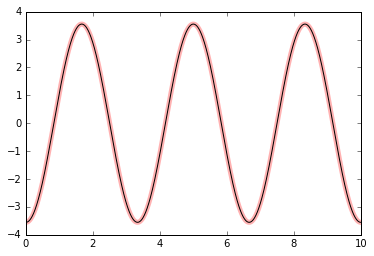

In [21]:
ham = schroedinger_1d(natoms=1, nmesh=1000)
period = ham.xLength / ham.natoms / 3.
psi = np.cos(2.*np.pi*ham.mesh/period)

psi_pp_numeric = ham.get_laplacian(psi)
psi_pp_exact = -(2.*np.pi/period)**2. * \
        np.cos(2.*np.pi*ham.mesh/period)

plt.figure()
plt.plot(ham.mesh, psi_pp_exact, '-r', lw=5, alpha=0.3)
plt.plot(ham.mesh, psi_pp_numeric, '-k')

### (3) Verify your implementation of 3.1 by comparing the residuum with the one you obtain when using the full Hamiltonian matrixd from Exercise 2.

In [31]:
# Copy exercise 2 into a funtion
def exercise2(fxn_pot, nmesh=100, xLength=10.):
    # define grid
    xvar, dx = np.linspace(0, xLength, nmesh, 
                           endpoint=False, retstep=True)

    # define Laplacian
    Imat = np.identity(nmesh)
    laplace = (np.roll(Imat, 1, axis=0) - 2*Imat + np.roll(Imat, -1, axis=0))/dx**2

    # define potential
    potential = np.eye(nmesh) * fxn_pot

    # define Hamiltonian
    hamiltonian = -laplace/2. + potential

    # get eigenvalues and eigenvectors
    eigval, eigvec = lg.eigh(hamiltonian)
    
    return eigval, eigvec.T

In [34]:
# define parameters
nmesh = 100
xLength = 10.
natoms = 2
Vscale = 20
pot_type = 'square'

# calculate residuals
ham = schroedinger_1d(nmesh=nmesh, xLength=xLength, natoms=natoms, 
                     Vscale=Vscale, pot_type=pot_type)

# calculate eigenvalues and eigenvectors
eigval, eigvec = exercise2(fxn_pot=ham.get_potential(), nmesh=nmesh, 
                           xLength=xLength)

error_list = []

for psi in eigvec:
    psi_res = ham.get_residual(psi)
    error = lg.norm(psi_res)
    error_list.append(error)
    
print('Max error = {:e}, Min error = {:e}'.format(max(error_list), min(error_list)))

Max error = 4.067668e-13, Min error = 5.577659e-14


### (4) Implement the following approach to iteratively improve the wavefunction (with $\alpha$ a suitably chosen scalar):
$$
\rvert\psi^\text{n+1}\rangle = \rvert\psi^\text{n}\rangle + 
\alpha \rvert\Delta\psi^\text{n, res}\rangle.
$$

See `get_state` method above.

### (5) Normalize the wavefunction $\rvert\psi^\text{n+1}\rangle$:
$$
\rvert\psi^\text{n+1}\rangle = \frac{\rvert\psi^\text{n+1}\rangle}
{\sqrt{\langle\psi^\text{n+1}\rvert\psi^\text{n+1}\rangle}}
$$

Seee `normalize_psi` method above.

### (6) Implement a method to construct an initial trial wavefunction (e.g. a constant or random numbers).  Run this trial through the iterative approach described above and monitor the convergence by plotting the energy
$$ 
    E^n = \langle\psi^n\rvert 
          \boldsymbol{\hat{H}}
          \rvert\psi^n\rangle.
$$

### Optimize $\alpha$ to achieve a stable and fast convergence.

#### Gerard's note: I combined tasks (7)-(9).

reached convergence at step 1141, error=9.989342e-06


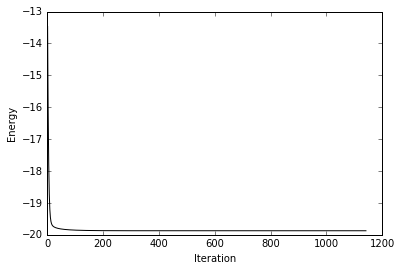

In [36]:
ham = schroedinger_1d(nmesh=nmesh, xLength=xLength, natoms=natoms, Vscale=Vscale, alpha=0.009)
ham.get_nstates(nstates=1, max_steps=100000, max_error=1e-5)

plt.figure()
for energies in ham.intermed_energy_list:
    plt.plot(np.arange(len(energies))+1, energies, '-k')
plt.xlabel('Iteration')
plt.ylabel('Energy')

In [37]:
# define range of alpha to be explored
alpha_array = np.linspace(0.001, 0.01, 20)
execution_time = []

# creaate class instance
for alpha in alpha_array:
    time_start = time.time()
    ham = schroedinger_1d(nmesh=nmesh, xLength=xLength, natoms=natoms, Vscale=Vscale, alpha=alpha)
    ham.get_nstates(nstates=1, max_steps=100000, max_error=1e-5)
    execution_time.append(time.time()-time_start)

reached convergence at step 10307, error=9.999937e-06
reached convergence at step 6993, error=9.991947e-06
reached convergence at step 5291, error=9.988229e-06
reached convergence at step 4255, error=9.984514e-06
reached convergence at step 3558, error=9.982402e-06
reached convergence at step 3057, error=9.981359e-06
reached convergence at step 2680, error=9.962198e-06
reached convergence at step 2385, error=9.976081e-06
reached convergence at step 2149, error=9.958524e-06
reached convergence at step 1955, error=9.966549e-06
reached convergence at step 1793, error=9.976723e-06
reached convergence at step 1656, error=9.968761e-06
reached convergence at step 1538, error=9.989104e-06
reached convergence at step 1436, error=9.981672e-06
reached convergence at step 1347, error=9.948106e-06
reached convergence at step 1268, error=9.947623e-06
reached convergence at step 1198, error=9.923190e-06
reached convergence at step 1135, error=9.928666e-06
Failed to reach convergence. Error = 3.223725

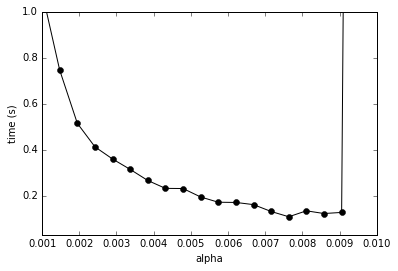

In [41]:
plt.figure()
plt.plot(alpha_array, execution_time, '-ko')
plt.ylim([0.03, 1.])
plt.xlabel('alpha')
plt.ylabel('time (s)')

### (7) Extend the above algorithm to excited states by projecting out the lower lying states using the Gram-Schmidt orthogonalization when performing step (4).  Compare the results with task (2).

In [59]:
alpha = 0.009
nstates = 6
ham = schroedinger_1d(nmesh=nmesh, xLength=xLength, natoms=natoms, Vscale=Vscale, 
                     alpha=alpha, pot_type='square')
ham.get_nstates(nstates=nstates, max_steps=100000, max_error=1e-5)

reached convergence at step 1141, error=9.989342e-06
reached convergence at step 645, error=9.826428e-06
reached convergence at step 456, error=9.976994e-06
reached convergence at step 790, error=9.898783e-06
reached convergence at step 360, error=9.837817e-06
reached convergence at step 439, error=9.428598e-06
const


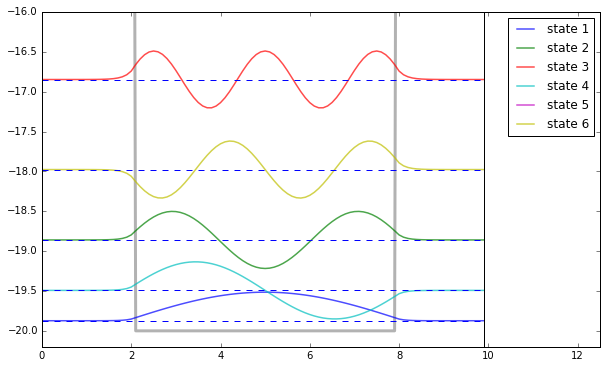

In [58]:
plt.figure(figsize=(10, 6))
scale = 2
padding = 2.5

ymin = -ham.Vscale - 0.2
ymax = -16.

plt.plot(ham.mesh, ham.get_potential(), '-k', lw=3, alpha=0.3)
for ii in xrange(nstates):
    eigvec = ham.psi_list[ii]
    eigval = ham.energy_list[ii]
    plt.plot(ham.mesh, scale*eigvec + eigval*np.ones(ham.nmesh),
            lw=1.5, alpha=0.7, label='state '+str(ii+1))
    plt.plot(ham.mesh, eigval*np.ones(ham.nmesh), '--b', lw=1.)

plt.plot(np.ones(2)*(ham.xLength-ham.dx), [ymin, ymax], 'k')
    
plt.xlim([0, ham.xLength + padding])
plt.ylim([ymin, ymax])
plt.legend(loc=1)

## ADVANCED QUESTIONS/TASKS

### (8) Measure and compare the timing of the approach between the direct and the iterative approach.